In [1]:
import pandas as pd
from dataretrieval import nwis
import numpy as np
import os
os.getcwd()
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import math
from datetime import datetime
# Get the current time
current_time = datetime.now()

# Print the current time
print("Current time:", current_time)
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
              "13296000"
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

Current time: 2025-04-08 08:24:44.955171


In [2]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]
#print(filtered_df)

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate) 
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

site_info_df:   agency_cd   site_no                              station_nm site_tp_cd  \
0      USGS  13296000  YANKEE FORK SALMON RIVER NR CLAYTON ID         ST   

   lat_va  long_va  dec_lat_va  dec_long_va coord_meth_cd  coord_acy_cd  ...  \
0  441632  1144404   44.278889  -114.733889             N             1  ...   

  local_time_fg reliability_cd  gw_file_cd  nat_aqfr_cd  aqfr_cd aqfr_type_cd  \
0             Y            NaN    NNNNNNNN          NaN      NaN          NaN   

  well_depth_va hole_depth_va  depth_src_cd  project_no  
0           NaN           NaN           NaN         NaN  

[1 rows x 42 columns]
station_nm: YANKEE FORK SALMON RIVER NR CLAYTON ID


In [3]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

             date      tmean   site_no  Days_Since_October_1st     rad_d
0      1995-01-01 -18.306002  06038800                      92  1.583707
1      1995-01-02 -17.829000  06038800                      93  1.600921
2      1995-01-03 -18.317001  06038800                      94  1.618135
3      1995-01-04 -15.904000  06038800                      95  1.635350
4      1995-01-05 -11.903001  06038800                      96  1.652564
...           ...        ...       ...                     ...       ...
282875 2024-10-10  14.149199  13342500                       9  0.154928
282876 2024-10-11  13.611249  13342500                      10  0.172142
282877 2024-10-12  16.385151  13342500                      11  0.189356
282878 2024-10-13  14.676150  13342500                      12  0.206570
282879 2024-10-14  16.204950  13342500                      13  0.223785

[282880 rows x 5 columns]


In [4]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  
  '00010_Mean', '00060_Mean', 
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

In [5]:
# Count the number of NaN values in each column
na_count = result.isna().sum()

# Print the result
#print(na_count)

# Drop rows with any NaN values
df_cleaned = result.dropna()

# Print the cleaned DataFrame
print(df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4      1.404000  13296000  2011-10-05  0.068857         7.6       101.0   
5      0.116000  13296000  2011-10-06  0.086071         5.7       110.0   
6      1.584000  13296000  2011-10-07  0.103285         6.0        94.0   
7      3.003000  13296000  2011-10-08  0.120499         6.4        90.3   
8      3.881000  13296000  2011-10-09  0.137714         5.5        85.9   
...         ...       ...         ...       ...         ...         ...   
4585  13.100349  13296000  2024-09-26  6.197114        10.9        53.5   
4586  13.638500  13296000  2024-09-27  6.214328        10.0        53.0   
4587  15.431150  13296000  2024-09-28  6.231543         9.8        52.6   
4588  10.443299  13296000  2024-09-29  6.248757         9.3        51.8   
4589   6.348950  13296000  2024-09-30  6.265971         7.9        51.4   

      Month  Year  
4        10  2011  
5        10  2011  
6        10  2011  
7        10  2011  

In [6]:
def get_water_year(date):
        if date.month >= 10: 
            #print(date)
            return date.year +1
            #print(date.year+1)
        else:   
            return date.year



df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)

print(df_cleaned)

print(df_cleaned['water_year'].unique())

          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4      1.404000  13296000  2011-10-05  0.068857         7.6       101.0   
5      0.116000  13296000  2011-10-06  0.086071         5.7       110.0   
6      1.584000  13296000  2011-10-07  0.103285         6.0        94.0   
7      3.003000  13296000  2011-10-08  0.120499         6.4        90.3   
8      3.881000  13296000  2011-10-09  0.137714         5.5        85.9   
...         ...       ...         ...       ...         ...         ...   
4585  13.100349  13296000  2024-09-26  6.197114        10.9        53.5   
4586  13.638500  13296000  2024-09-27  6.214328        10.0        53.0   
4587  15.431150  13296000  2024-09-28  6.231543         9.8        52.6   
4588  10.443299  13296000  2024-09-29  6.248757         9.3        51.8   
4589   6.348950  13296000  2024-09-30  6.265971         7.9        51.4   

      Month  Year  water_year  
4        10  2011        2012  
5        10  2011        2012  
6  

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/1530779919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)


In [7]:
amp_df = pd.DataFrame({
                        "site": [ "00000000"],
      "water_year": [  0 ],
                        "amp": [ 0.0 ],
     "ph_l": [  0.0  ]
                                })

In [8]:
df_cleaned['sin_rday'] = np.sin( df_cleaned['rad_d'] )
df_cleaned['cos_rday'] = np.cos( df_cleaned['rad_d'] )

# Group by both site_no and water_year
grouped = df_cleaned.groupby(['site_no', 'water_year'])
print(grouped)

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/2698343029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sin_rday'] = np.sin( df_cleaned['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/2698343029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cos_rday'] = np.cos( df_cleaned['rad_d'] )


In [9]:

# Iterate through each group
for (site_no, water_year), group_df in grouped:
#    merged_df_wy=df_cleaned[df_cleaned['site_no']== site_no ]

    
    num_rows = group_df.shape[0]
    print("Number of rows:", num_rows)
    if num_rows < missing_data_threshold:
        print("stop")
    else:    
        print(f"Processing site_no: {site_no}, water_year: {water_year}")
        print(f"DataFrame shape: {group_df.shape}")
        print(group_df)

        air_model =    smf.ols('tmean ~ sin_rday + cos_rday',      data=  group_df ).fit()
        #print("air_model:",air_model.summary())
        air_model_coefficients = air_model.params
        air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
        group_df['fit_air'] = air_model.predict( group_df )
        
        group_df['ST']=group_df['00010_Mean']
        stream_model = smf.ols('ST ~ sin_rday + cos_rday', data= group_df ).fit()
        #print("stream_model:",stream_model.summary())
        stream_model_coefficients = stream_model.params
        stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
        #print("stream_amp:", stream_amp)
        group_df['fit_stream'] = stream_model.predict( group_df )
        ## phase
        ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
        ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )
        #print("ph_stream:", ph_stream)
        #print("ph_air:", ph_air)
        ph_l = ph_stream - ph_air
        ##
        amp_df0 = pd.DataFrame({
                                "site": [site_no]
           , "water_year": [  water_year ]
                                    ,"amp": [stream_amp / air_amp]
           , "ph_l": [ ph_l ]
                                })

        amp_df=pd.concat( [amp_df,amp_df0] )

amp_df = amp_df[1:]

Number of rows: 362
Processing site_no: 13296000, water_year: 2012
DataFrame shape: (362, 11)
         tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  Month  \
4     1.404000  13296000  2011-10-05  0.068857         7.6       101.0     10   
5     0.116000  13296000  2011-10-06  0.086071         5.7       110.0     10   
6     1.584000  13296000  2011-10-07  0.103285         6.0        94.0     10   
7     3.003000  13296000  2011-10-08  0.120499         6.4        90.3     10   
8     3.881000  13296000  2011-10-09  0.137714         5.5        85.9     10   
..         ...       ...         ...       ...         ...         ...    ...   
361  10.771001  13296000  2012-09-26  6.197114         8.9        70.6      9   
362  11.411000  13296000  2012-09-27  6.214328         8.4        67.9      9   
363  10.860001  13296000  2012-09-28  6.231543         8.0        66.8      9   
364  11.108001  13296000  2012-09-29  6.248757         8.9        66.5      9   
365  11.576000 

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

In [10]:
amp_df

,site,water_year,amp,ph_l
0,13296000,2012,0.526541,5.808416
0,13296000,2013,0.577541,3.517767
0,13296000,2014,0.580962,7.228913
0,13296000,2015,0.677460,5.400417
0,13296000,2016,0.610012,7.725480
0,13296000,2017,0.483895,8.538532
0,13296000,2018,0.560827,2.922541
0,13296000,2019,0.561320,7.963033
0,13296000,2020,0.545438,3.379963
0,13296000,2024,0.592375,2.040296


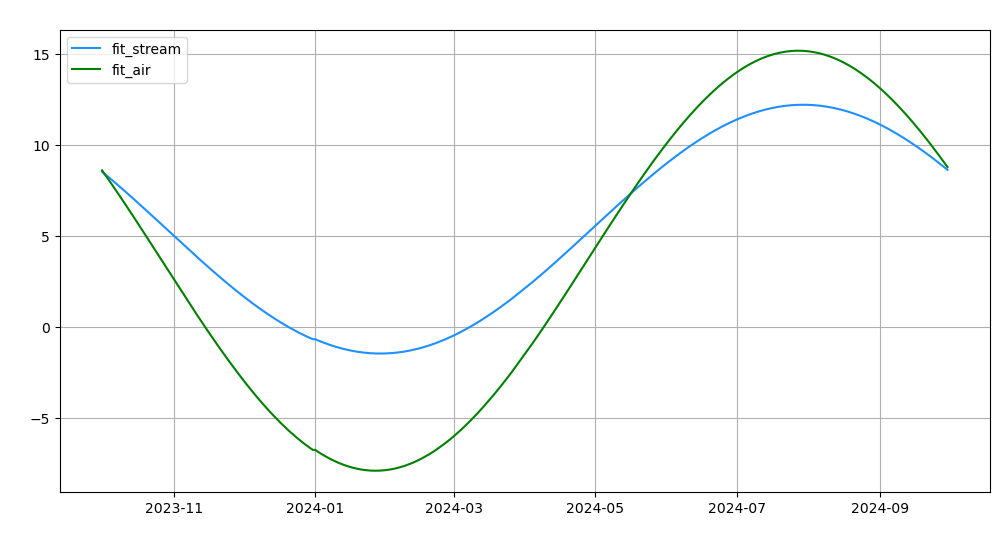

In [11]:
plt.figure(figsize=(12, 6))
plt.plot( group_df['Date'],  group_df['fit_stream'], label='fit_stream', color='dodgerblue')
plt.plot( group_df['Date'],  group_df['fit_air'], label='fit_air', color='green')

# Add labels, title, and legend
plt.xlabel(' ')
plt.ylabel(' ')
plt.title(' ')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

for summer

summer_months = [6,7,8]

summer_missing_data_threshold = 0.90 * (30+31+31)

In [12]:
amp_df_summer = pd.DataFrame({
                        "site": [ "00000000"],
      "water_year": [  0 ],
                        "amp": [ 0.0 ],
     "ph_l": [  0.0  ]
                                })

df_cleaned_summer = df_cleaned[ df_cleaned['Month'].isin(summer_months) ]

# Group by both site_no and water_year
grouped = df_cleaned_summer.groupby(['site_no', 'water_year'])
print(grouped)

for (site_no, water_year), group_df in grouped:

    
    num_rows = group_df.shape[0]
    print("Number of rows:", num_rows)
    if num_rows < summer_missing_data_threshold:
        print("stop")
    else:    
        print(f"Processing site_no: {site_no}, water_year: {water_year}")
        print(f"DataFrame shape: {group_df.shape}")
        print(group_df)

        air_model =    smf.ols('tmean ~ sin_rday + cos_rday',      data=  group_df ).fit()
        #print("air_model:",air_model.summary())
        air_model_coefficients = air_model.params
        air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
        group_df['fit_air'] = air_model.predict( group_df )
        
        group_df['ST']=group_df['00010_Mean']
        stream_model = smf.ols('ST ~ sin_rday + cos_rday', data= group_df ).fit()
        #print("stream_model:",stream_model.summary())
        stream_model_coefficients = stream_model.params
        stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
        #print("stream_amp:", stream_amp)
        group_df['fit_stream'] = stream_model.predict( group_df )
        ## phase
        ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
        ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )
        #print("ph_stream:", ph_stream)
        #print("ph_air:", ph_air)
        ph_l = ph_stream - ph_air
        ##
        amp_df_summer0 = pd.DataFrame({
                                "site": [site_no]
           , "water_year": [  water_year ]
                                    ,"amp": [stream_amp / air_amp]
           , "ph_l": [ ph_l ]
                                })

        amp_df_summer=pd.concat( [ amp_df_summer,amp_df_summer0] )

amp_df_summer = amp_df_summer[1:]

Number of rows: 92
Processing site_no: 13296000, water_year: 2012
DataFrame shape: (92, 11)
         tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  Month  \
244  12.286000  13296000  2012-06-01  4.183052         7.4       908.0      6   
245  11.739000  13296000  2012-06-02  4.200266         6.9      1220.0      6   
246  12.838000  13296000  2012-06-03  4.217481         6.7      1450.0      6   
247  13.845000  13296000  2012-06-04  4.234695         6.8      1560.0      6   
248   1.696000  13296000  2012-06-05  4.251909         5.0      1700.0      6   
..         ...       ...         ...       ...         ...         ...    ...   
331  16.719000  13296000  2012-08-27  5.680688        11.7        84.6      8   
332  16.739000  13296000  2012-08-28  5.697902        11.8        81.5      8   
333  12.680000  13296000  2012-08-29  5.715116        11.0        79.8      8   
334  13.112000  13296000  2012-08-30  5.732331         9.9        79.0      8   
335  14.972001  1

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/1470340805.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/1470340805.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_10894/1470340805.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

In [13]:
amp_df_summer

,site,water_year,amp,ph_l
0,13296000,2012,0.854532,-4.464985
0,13296000,2013,0.927351,-2.933081
0,13296000,2014,0.617119,9.364139
0,13296000,2015,1.748728,4.185668
0,13296000,2016,1.226899,-8.672774
0,13296000,2018,0.621657,3.578961
0,13296000,2019,0.960585,1.381752
0,13296000,2020,0.665838,12.837870
0,13296000,2024,0.777238,3.614263
